# COVID-19 cases in Mexican States and factors

This Notebook downloads Geopandas GeoDataFrames for States (admin1) and Municipalities (admin2) derived from the 2020 Mexican Census: [INEGI](https://www.inegi.org.mx/temas/mg/).

For details how these dataframe were created, see the [mexican-boundaries](https://github.com/sbl-sdsc/mexico-boundaries) GitHub project.

In [1]:
from io import BytesIO
from urllib.request import urlopen
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [2]:
pd.options.display.max_rows = None  # display all rows
pd.options.display.max_columns = None  # display all columsns

## Boundaries of Mexican Municipalities

Read boundary polygons for Mexican states from shapefile

In [3]:
admin1_url = 'https://raw.githubusercontent.com/sbl-sdsc/mexico-boundaries/main/data/mexico_admin1.parquet'

In [4]:
resp = urlopen(admin1_url)
admin1 = gpd.read_parquet(BytesIO(resp.read()))

Calculate the area of each state (convert area from m^2 to km^2

In [5]:
admin1.crs

<Projected CRS: PROJCRS["MEXICO_ITRF_2008_LCC",BASEGEOGCRS["MEXICO ...>
Name: MEXICO_ITRF_2008_LCC
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: International Terrestrial Reference Frame 2008
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [6]:
admin1['area_sqkm'] = admin1['geometry'].area/ 10**6

In [7]:
admin1['CVE_ENT'] = admin1['CVE_ENT']+['000']

In [8]:
admin1.rename(columns={"CVE_ENT":"cve_ent"},
                                  inplace=True)

In [9]:
admin1.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986


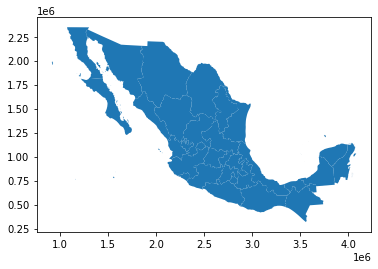

In [10]:
admin1.plot();

## Map of Population by State

Get population from COVID-19 data files

In [11]:
All_admin1 = pd.read_csv('../Data/ComorbilitiesStates.csv')
All_admin1.head()

,cve_ent,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
0,1000,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478
1,2000,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848
2,3000,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750
3,4000,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917
4,5000,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806


Add 5-digit municipality code column (example: convert 5035 -> 05035)

In [12]:
All_admin1['cve_ent'] = All_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

In [13]:
All_admin1.head()

,cve_ent,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
0,01000,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478
1,02000,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848
2,03000,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750
3,04000,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917
4,05000,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806


Merge the geo dataframe with the population dataframe using the common CVE_MUNI column

In [14]:
df_admin1 = admin1.merge(All_admin1, on='cve_ent')

In [15]:
df_admin1.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806


In [16]:
df_admin1['pop_density']=df_admin1['population']/df_admin1['area_sqkm']
df_admin1['total_obesity_up20years']=df_admin1['population']*df_admin1['pct_obesity_up20years']/100
df_admin1['total_hypertension_up20years']=df_admin1['population']*df_admin1['pct_hypertension_up20years']/100
df_admin1['total_diabetes_up20years']=df_admin1['population']*df_admin1['pct_diabetes_up20years']/100
df_admin1['ob_density']=df_admin1['total_obesity_up20years']/df_admin1['pop_density']
df_admin1['ob_100']=df_admin1['total_obesity_up20years']/100000
df_admin1['hy_density']=df_admin1['total_hypertension_up20years']/df_admin1['pop_density']
df_admin1['hy_100']=df_admin1['total_hypertension_up20years']/100000
df_admin1['db_density']=df_admin1['total_diabetes_up20years']/df_admin1['pop_density']
df_admin1['db_100']=df_admin1['total_diabetes_up20years']/100000
df_admin1.head()


,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125


Merge the geo dataframe with the population dataframe using the common CVE_MUNI column

### Calculate Total COVID-19 cases by State

In [17]:
#df_admin2['population_density'] = df_admin2['poblacion'] / df_admin2['area_sqkm']

In [18]:
a2 = df_admin1[['total_cases']]

In [19]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
X = pd.DataFrame(std_scaler.fit_transform(a2))

X.head(10)

,0
0,-0.586630
1,0.047541
2,-0.327973
3,-1.005880
4,0.561281
5,-0.976068
6,-0.979966
7,0.241090
8,16.805180
9,-0.374451


In [20]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 13
Silhouette Coefficient: 0.153


In [21]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [22]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [23]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,-1
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,0
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,1
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,-1


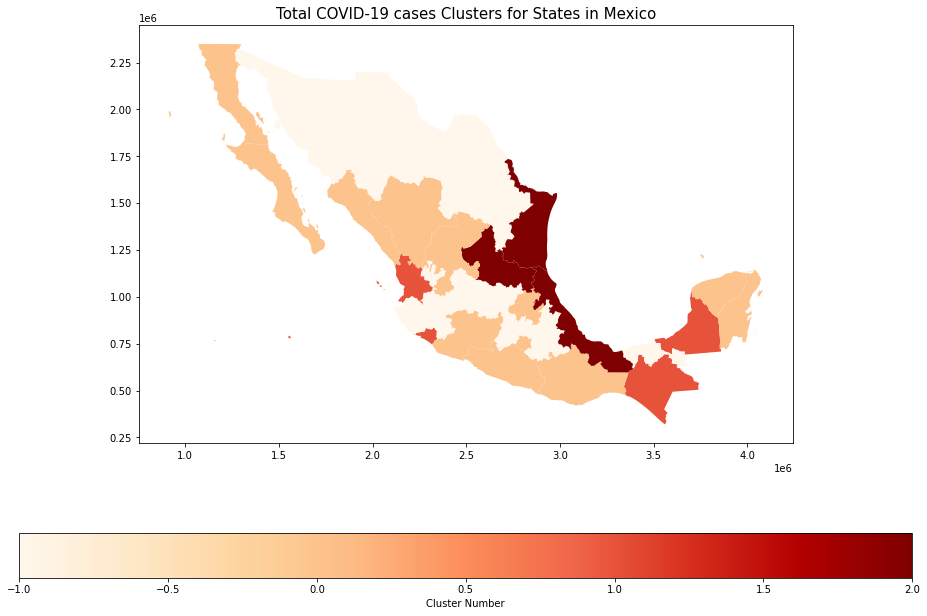

In [24]:
title = 'Total COVID-19 cases Clusters for States in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

In [25]:
# try Plotly with KDE density plot
# bubble maps (see Ebola example with time series):
# https://plotly.com/python/bubble-maps/

Plot population data

### Calculate rate of cases by State

In [26]:
#rcases_admin1 =df_admin1[["cve_ent", "state", "cases_rates"]]

In [27]:
#rcases_admin1['cve_ent'] = rcases_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

In [28]:
#dfrc_admin1 = admin1.merge(rcases_admin1, on='cve_ent')

In [29]:
a2 = df_admin1[['cases_rates']]

In [30]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
X = pd.DataFrame(std_scaler.fit_transform(a2))

X.head(10)

,0
0,0.276714
1,-0.259518
2,3.256396
3,-0.567582
4,0.608453
5,-0.066938
6,-1.577213
7,-0.114861
8,6.577963
9,0.265331


In [31]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 12
Silhouette Coefficient: 0.220


In [32]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [33]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [34]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,-1
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,2
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,-1


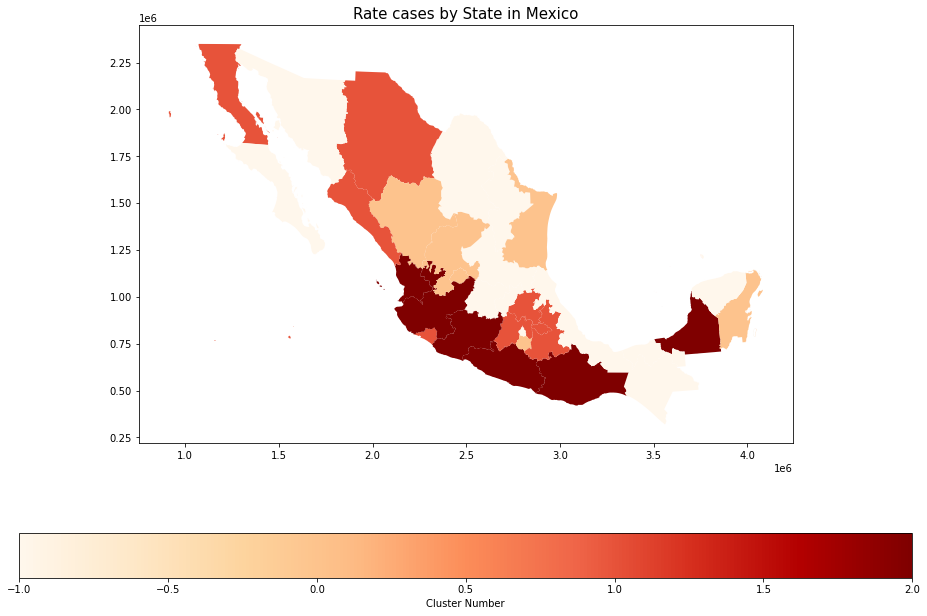

In [35]:
title = 'Rate cases by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate Total Deaths by State

In [36]:
#deaths_admin1 =All_admin1[["cve_ent", "state", "total_deaths"]]

In [37]:
#deaths_admin1['cve_ent'] = deaths_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

In [38]:
#dfd_admin1 = admin1.merge(deaths_admin1, on='cve_ent')

In [39]:
a3 = df_admin1[['total_deaths']]

In [40]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.477867
1,0.754004
2,-0.670845
3,-0.714613
4,0.301999
5,-0.725754
6,-0.637223
7,0.524222
8,5.889386
9,-0.470108


In [41]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 4
Estimated number of noise points: 11
Silhouette Coefficient: 0.331


In [42]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [43]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [44]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,-1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,1
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,1
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,2


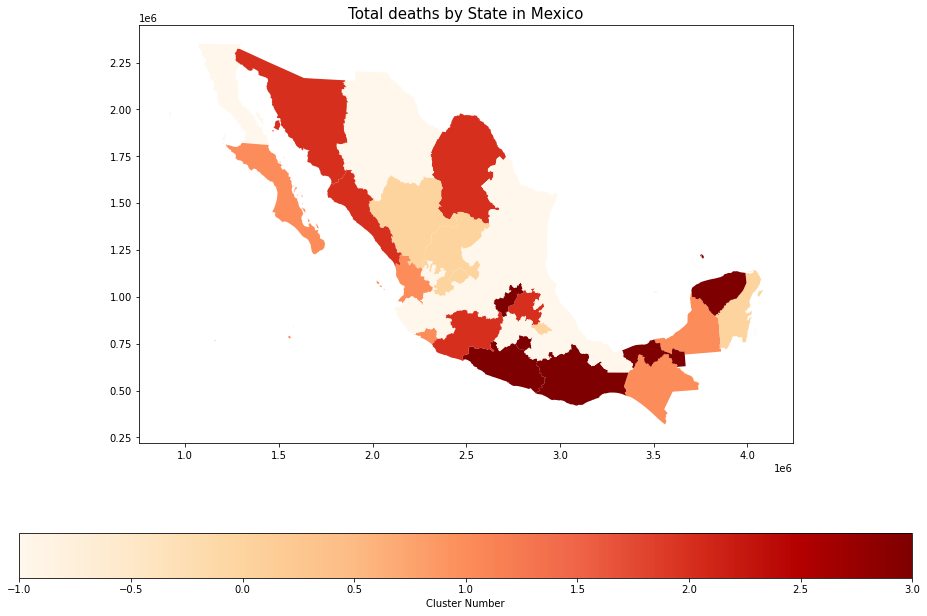

In [45]:
title = 'Total deaths by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate rate of deaths by State

In [46]:
#rdeaths_admin1 =All_admin1[["cve_ent", "state", "deaths_rates"]]

In [47]:
#rdeaths_admin1['cve_ent'] = rdeaths_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

In [48]:
#dfd_admin1 = admin1.merge(rdeaths_admin1, on='cve_ent')

In [49]:
a3 = df_admin1[['deaths_rates']]

In [50]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.039183
1,1.253323
2,0.221739
3,-0.904505
4,0.481849
5,-0.370100
6,-2.795883
7,0.462786
8,4.046409
9,-0.769448


In [51]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 4
Estimated number of noise points: 9
Silhouette Coefficient: 0.281


In [52]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [53]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [54]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,-1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,1
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,2


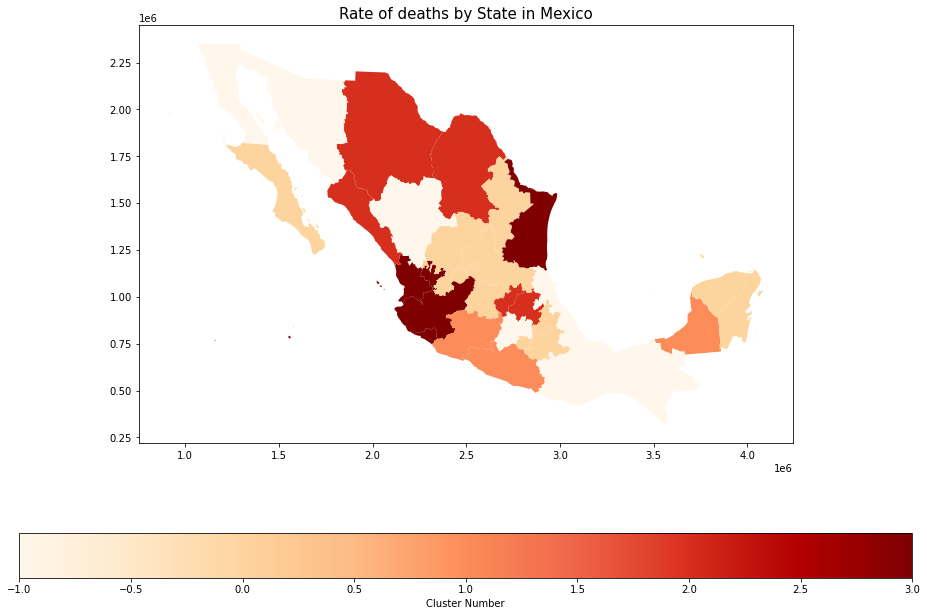

In [55]:
title = 'Rate of deaths by State in Mexico'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate comorbilities (Obesity) by State

In [56]:
#obesity_admin1 =All_admin1[["cve_ent", "state", "pct_obesity_up20years"]]

In [57]:
#obesity_admin1['cve_ent'] = obesity_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

In [58]:
#dfd_admin1 = admin1.merge(obesity_admin1, on='cve_ent')

In [59]:
a3 = df_admin1[['ob_density']]

In [60]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-1.017561
1,0.721295
2,0.522293
3,0.213831
4,1.808769
5,-0.982879
6,-0.012653
7,3.809856
8,-1.083088
9,1.254214


In [61]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 4
Estimated number of noise points: 7
Silhouette Coefficient: 0.487


In [62]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [63]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [64]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,-1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,-1
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,1
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,-1


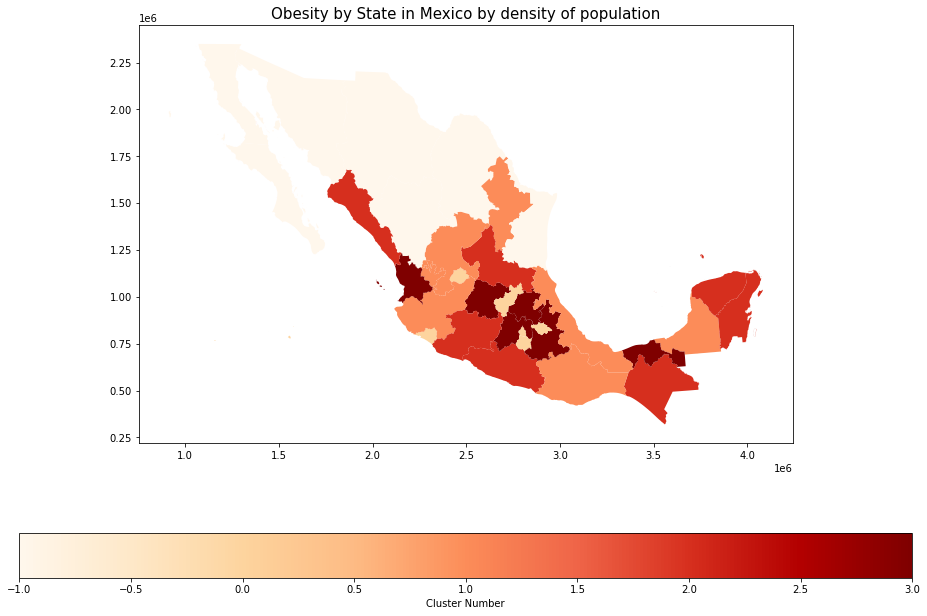

In [65]:
title = 'Obesity by State in Mexico by density of population'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

In [66]:
a3 = df_admin1[['ob_100']]

In [67]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.778867
1,0.525230
2,-0.902949
3,-0.797341
4,-0.028170
5,-0.908711
6,0.425316
7,0.234042
8,2.060543
9,-0.541567


In [68]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 5
Estimated number of noise points: 11
Silhouette Coefficient: 0.344


In [69]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [70]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [71]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,-1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,-1
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,0
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,1


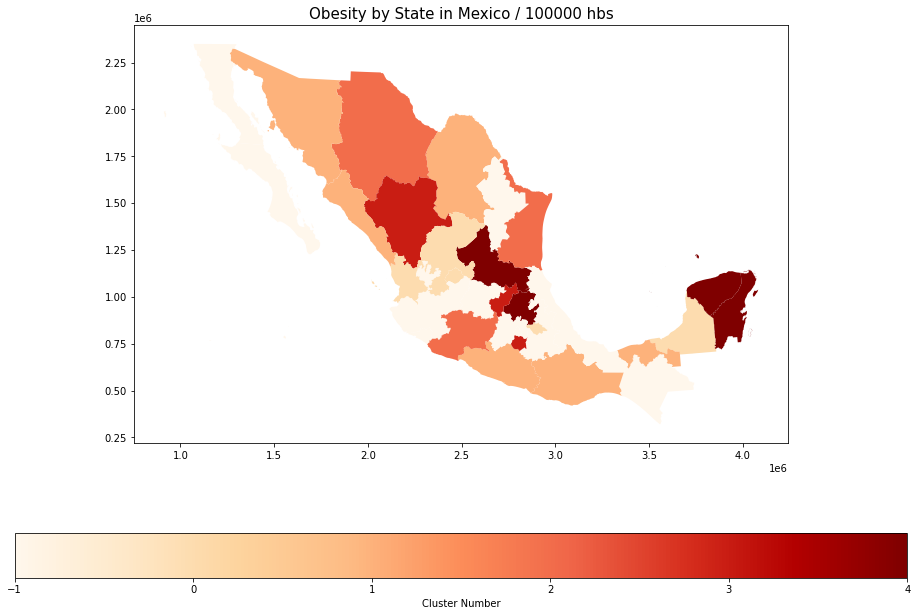

In [72]:
title = 'Obesity by State in Mexico / 100000 hbs'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate comorbilities (Hypertension) by State

In [73]:
#hypertension_admin1 =All_admin1[["cve_ent", "state", "pct_hypertension_up20years"]]

In [74]:
#hypertension_admin1['cve_ent'] = hypertension_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

In [75]:
#dfd_admin1 = admin1.merge(hypertension_admin1, on='cve_ent')

In [76]:
a3 = df_admin1[['hy_density']]

In [77]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-1.020672
1,0.439750
2,0.119080
3,0.390219
4,2.267146
5,-1.003327
6,0.090805
7,4.471179
8,-1.072275
9,1.367009


In [78]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 4
Estimated number of noise points: 9
Silhouette Coefficient: 0.428


In [79]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [80]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [81]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,2
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,1
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,-1


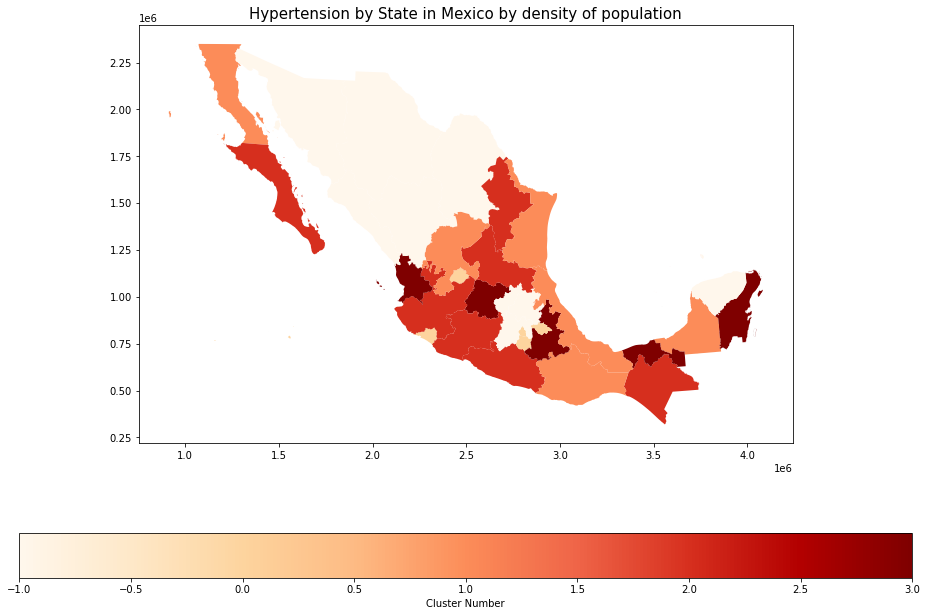

In [82]:
title = 'Hypertension by State in Mexico by density of population'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

In [83]:
a3 = df_admin1[['hy_100']]

In [84]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.688679
1,0.265228
2,-0.822998
3,-0.601792
4,0.191553
5,-0.819283
6,0.552756
7,0.430253
8,2.092669
9,-0.399475


In [85]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 3
Estimated number of noise points: 10
Silhouette Coefficient: 0.375


In [86]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [87]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [88]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,0
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,1


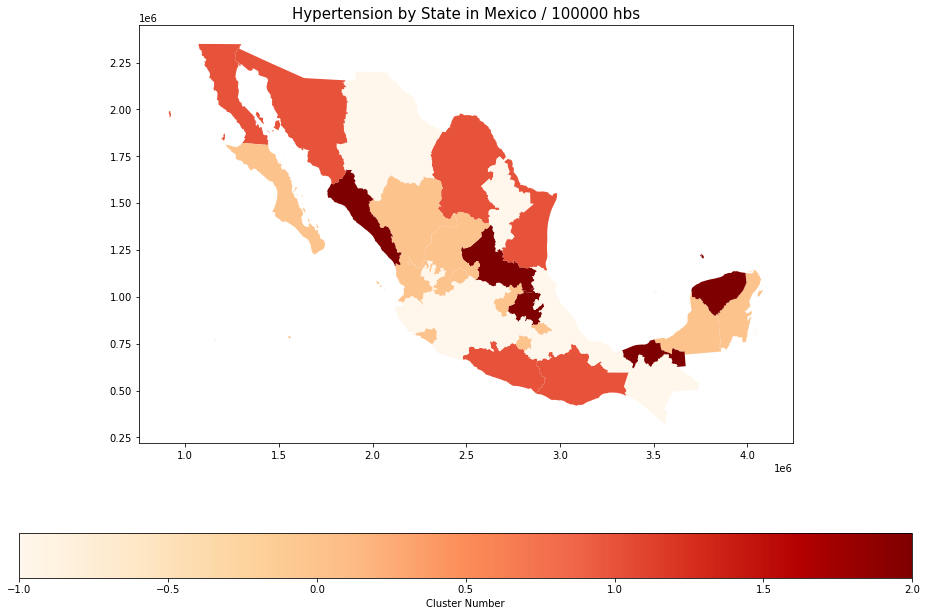

In [89]:
title = 'Hypertension by State in Mexico / 100000 hbs'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

### Calculate comorbilities (Diabetes) by State

In [90]:
#diabetes_admin1 =All_admin1[["cve_ent", "state", "pct_diabetes_up20years"]]

In [91]:
#diabetes_admin1['cve_ent'] = diabetes_admin1['cve_ent'].apply(lambda i: f'{i:05d}')

In [92]:
#dfd_admin1 = admin1.merge(diabetes_admin1, on='cve_ent')

In [93]:
a3 = df_admin1[['db_density']]

In [94]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-1.008271
1,0.274460
2,0.062559
3,0.401930
4,2.364747
5,-0.970626
6,-0.022149
7,3.152705
8,-1.051282
9,1.383940


In [95]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 4
Estimated number of noise points: 8
Silhouette Coefficient: 0.476


In [96]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [97]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [98]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,1
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,2
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,-1


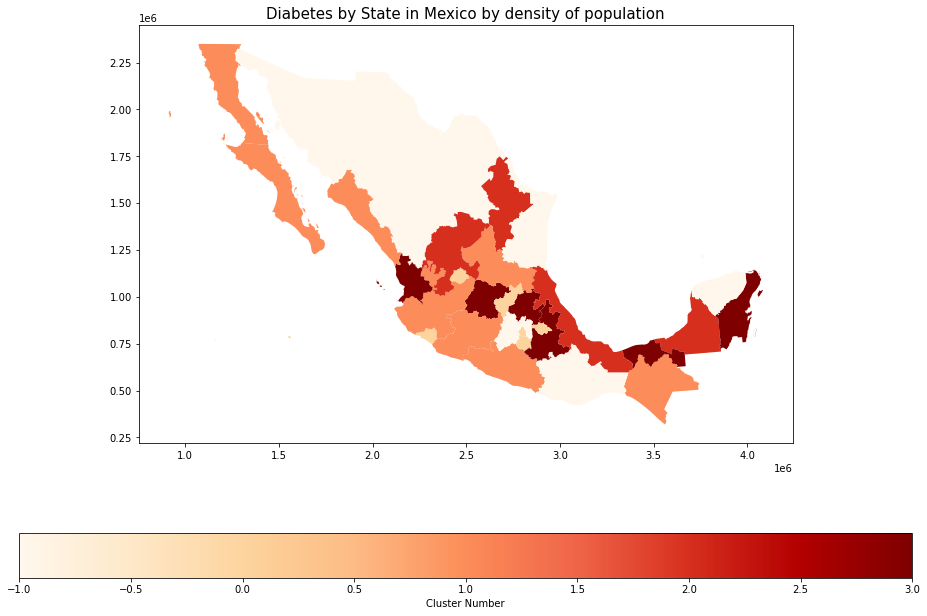

In [99]:
title = 'Diabetes by State in Mexico by density of population'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);

In [100]:
a3 = df_admin1[['db_100']]

In [101]:
#std_scaler = StandardScaler()
std_scaler = RobustScaler()
#std_scaler = MinMaxScaler()
std_scaler
# fit and transform the data
Xd = pd.DataFrame(std_scaler.fit_transform(a3))

Xd.head(10)

,0
0,-0.825668
1,0.048606
2,-0.966891
3,-0.716428
4,0.168104
5,-0.906148
6,0.337011
7,0.010999
8,2.730568
9,-0.497796


In [102]:
# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=3).fit(Xd)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
#with np.printoptions(threshold=np.inf):
#     print(labels)
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(Xd, labels))

Estimated number of clusters: 5
Estimated number of noise points: 6
Silhouette Coefficient: 0.431


In [103]:
df_labels = pd.DataFrame(labels, columns=['cluster'])

In [104]:
df2 = pd.concat([df_admin1, df_labels], axis=1)

In [105]:
df2.head()

,CVEGEO,cve_ent,NOMGEO,geometry,area_sqkm,state,population,total_cases,cases_rates,total_cases_last_60_days,cases_rate_last_60_days,total_deaths,deaths_rates,total_deaths_last_60_days,deaths_rate_last_60_days,pct_obesity_up20years,pct_hypertension_up20years,pct_diabetes_up20years,pop_density,total_obesity_up20years,total_hypertension_up20years,total_diabetes_up20years,ob_density,ob_100,hy_density,hy_100,db_density,db_100,cluster
0,01,01000,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",5558.673843,AGUASCALIENTES,1434635,26695,1860.752038,828,57.715029,2456,171.193370,88,6.133964,32.593387,14.700566,7.556478,258.089437,4.675961e+05,210899.468406,108407.877143,1811.760057,4.675961,817.156530,2.108995,420.039962,1.084079,0
1,02,02000,Baja California,"MULTIPOLYGON (((1493197.166 1849625.247, 14934...",73516.697324,BAJA CALIFORNIA,3634868,50286,1383.434006,2403,66.109691,8648,237.917856,177,4.869503,48.366995,21.007712,9.974848,49.442754,1.758076e+06,763602.586663,362572.569947,35557.817510,17.580764,15444.175755,7.636026,7333.179054,3.625726,1
2,03,03000,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",73970.687326,BAJA CALIFORNIA SUR,804708,36317,4513.065609,6423,798.177724,1486,184.663257,118,14.663704,42.849118,16.536911,8.369750,10.878742,3.448103e+05,133073.848409,67352.045269,31695.787122,3.448103,12232.466972,1.330738,6191.161367,0.673520,0
3,04,04000,Campeche,"MULTIPOLYGON (((3544897.199 946994.621, 354491...",57254.511636,CAMPECHE,1000617,11099,1109.215614,1666,166.497271,1266,126.521936,58,5.796424,44.903811,26.108154,14.007917,17.476649,4.493152e+05,261242.627768,140165.598683,25709.457481,4.493152,14948.096096,2.612426,8020.164459,1.401656,0
4,05,05000,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",150671.222986,COAHUILA,3218720,69397,2156.043396,1391,43.215937,6376,198.091167,70,2.174778,37.606715,22.397551,12.343806,21.362540,1.210455e+06,720914.443319,397312.546367,56662.498160,12.104549,33746.663532,7.209144,18598.563177,3.973125,2


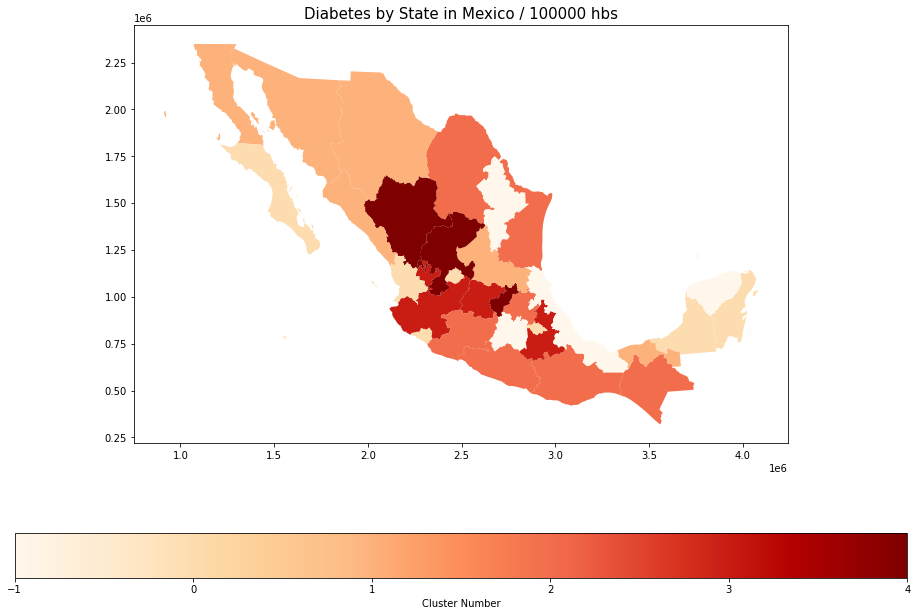

In [106]:
title = 'Diabetes by State in Mexico / 100000 hbs'
ax1 = df2.plot(column='cluster', 
#               cmap='OrRd',
# color maps: https://matplotlib.org/stable/tutorials/colors/colormaps.html
               cmap='OrRd',
               legend=True, 
               legend_kwds={'label': 'Cluster Number', 
                            'orientation': 'horizontal'},
               figsize=(16, 11));
ax1.set_title(title, fontsize=15);